In [47]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# np.random.seed(2019)
# %matplotlib inline

# df = pd.read_csv('../data/metadata.csv')

# df = df[['finding', 'view', 'filename']]

# df = df[df['view'] != 'Axial']

# # print(df['finding'])

# df['finding'].value_counts().plot(kind='bar')

# covid = df[['finding', 'filename']]
# covid["covid"] = np.array(df['finding'] == 'COVID-19', dtype=int)
# covid["sars"] = np.array(df['finding'] == 'SARS', dtype=int)
# covid['valid_split'] = np.array(np.random.uniform(0, 1, len(covid)) > 0.8, dtype=int)

# del covid['finding']

# covid.to_csv('../data/covid19.csv', index=False)


In [48]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [49]:
import os
import pandas as pd
import numpy as np
from itertools import cycle
from fastai.vision import *
from fastai.metrics import *

torch.manual_seed(121)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(121)

In [50]:
data_csv = Path('../data/covid19.csv')

ALL_LBLS = ['No Finding',
            'Cardiomegaly',
            'Edema',
            'Consolidation',
            'Atelectasis',
            'Pleural Effusion',
            'Enlarged Cardiomediastinum',
            'Lung Opacity',
            'Lung Lesion',
            'Pneumonia',
            'Pneumothorax',
            'Pleural Other',
            'Fracture',
            'Support Devices']

EVAL_LBLS = ['Cardiomegaly',
             'Edema',
             'Consolidation',
             'Atelectasis',
             'Pleural Effusion',]

BS = 16
IMG_SZ = 320
IMG_MEAN = torch.FloatTensor([0.5027, 0.5027, 0.5027])
IMG_STD = torch.FloatTensor([0.2915, 0.2915, 0.2915])

GPU_IDS = [0]
torch.cuda.set_device(GPU_IDS[0])

EXP = 'fastai-densenet-320-covid'
RES_DIR = 'results/'+EXP+'/'
os.makedirs('results/', exist_ok=True)
os.makedirs(RES_DIR, exist_ok=True)

In [51]:
data_tfms = get_transforms(do_flip=True, flip_vert=False, max_rotate=None, max_zoom=1, max_lighting=None,
                          max_warp=0, p_affine=0, p_lighting=0)

data = ImageDataBunch.from_csv('../data/', csv_labels=data_csv, folder='images', seed=0,
                               label_col=['covid', 'sars'], delimiter=',', suffix='', valid_pct=0.2, ds_tfms=data_tfms,
                               bs=BS, size=IMG_SZ).normalize([IMG_MEAN, IMG_STD])

data

ImageDataBunch;

Train: LabelList (217 items)
x: ImageList
Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320)
y: MultiCategoryList
covid,covid,covid,covid,covid
Path: ../data;

Valid: LabelList (54 items)
x: ImageList
Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320)
y: MultiCategoryList
covid,covid,covid,covid,covid
Path: ../data;

Test: None

In [52]:
print(np.sum(data.train_ds.y.items), np.size(data.train_ds.y))
print(np.sum(data.valid_ds.y.items), np.size(data.valid_ds.y))

168 217
45 54


In [53]:
from sklearn.metrics import roc_curve, auc

class AUC(Callback):

    def __init__(self, num_cl=2, pick='micro', plot_auc=False, plot_title=EXP+' - validation AUC', plot_path=RES_DIR+'valid_ROC_AUC.png'):
        self.id_to_class = {
            0: 'covid',
            1: 'sars',
            'micro': 'micro',
            'macro': 'macro',
        }
        self.name = str(self.id_to_class[pick])+'-AUC'
        self.pick = pick
        self.num_cl = num_cl
        self.plot_path = plot_path
        self.plot_title = plot_title
        self.plot_auc = plot_auc
        
    
    def on_epoch_begin(self, **kwargs):
        self.outputs, self.targets = [], []
    
    def on_batch_end(self, last_output, last_target, **kwargs):
        self.outputs.append(last_output)
        self.targets.append(last_target)
    
    def on_epoch_end(self, last_metrics, **kwargs):
        self.outputs = torch.sigmoid(torch.cat(self.outputs)).cpu().detach().numpy()
        self.targets = torch.cat(self.targets).cpu().numpy()
        fpr, tpr, roc_auc = {}, {}, {}
        for i in range(self.num_cl):
          fpr[i], tpr[i], _ = roc_curve(self.targets[:, i], self.outputs[:, i])
          roc_auc[self.id_to_class[i]] = auc(fpr[i], tpr[i])
        
        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(self.targets.ravel(), self.outputs.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(2)]))

        # Then interpolate all ROC curves at this points
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(2):
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

        # Finally average it and compute AUC
        mean_tpr /= 2

        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
        
        if self.plot_auc:
            # Plot all ROC curves
            plt.figure()
            plt.plot(fpr["micro"], tpr["micro"],
                     label='micro (auc- {0:0.2f})'.format(roc_auc["micro"]),
                     color='deeppink', linestyle=':', linewidth=2)

            plt.plot(fpr["macro"], tpr["macro"],
                     label='macro (auc- {0:0.2f})'.format(roc_auc["macro"]),
                     color='navy', linestyle=':', linewidth=2)

            colors = cycle(['blue', 'green', 'red', 'cyan', 'yellow', 'magenta', 'black'])
            for i, color in zip(range(2), colors):
                if roc_auc[self.id_to_class[i]] > 0:
                    plt.plot(fpr[i], tpr[i], color=color, lw=1,
                         label='{0} (auc- {1:0.2f})'.format(self.id_to_class[i], roc_auc[self.id_to_class[i]]))

            plt.plot([0, 1], [0, 1], 'k--', lw=2)
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('{}'.format(self.plot_title))
            plt.legend(loc="lower right")
            plt.savefig(self.plot_path)
            print('roc-auc curve saved to {}'.format(self.plot_path))
        
        return add_metrics(last_metrics, roc_auc[self.id_to_class[self.pick]])

acc_02 = partial(accuracy_thresh, thresh=0.4)

In [54]:
learn = cnn_learner(data, models.densenet121, metrics=[acc_02, AUC(pick=0), AUC(pick=1), AUC(pick='micro', plot_auc=True, plot_path=RES_DIR+'valid_ROC_AUC.png')], model_dir='../fastai/models/')
print(learn.model[-1][-1])
learn.model[-1][-1] = nn.Linear(512, 14, bias=True)
learn.load('fastai-densenet-320-u1-stage-1')
learn.model[-1][-1] = nn.Linear(512, 2, bias=True)
learn.model = torch.nn.DataParallel(learn.model, device_ids=GPU_IDS)

Linear(in_features=512, out_features=2, bias=True)


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


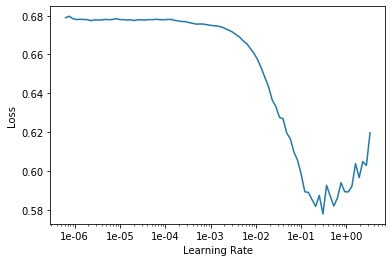

In [55]:
learn.freeze()
learn.lr_find();
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy_thresh,covid-AUC,sars-AUC,micro-AUC,time
0,0.646842,0.549671,0.805556,0.684091,1.000000,0.946737,00:11
1,0.547179,0.405737,0.833333,0.706818,0.830189,0.896649,00:11
2,0.467970,0.324948,0.888889,0.713636,0.943396,0.950617,00:10
3,0.404961,0.319274,0.879630,0.720455,0.943396,0.950617,00:11


roc-auc curve saved to results/fastai-densenet-320-covid/valid_ROC_AUC.png
roc-auc curve saved to results/fastai-densenet-320-covid/valid_ROC_AUC.png
roc-auc curve saved to results/fastai-densenet-320-covid/valid_ROC_AUC.png
roc-auc curve saved to results/fastai-densenet-320-covid/valid_ROC_AUC.png


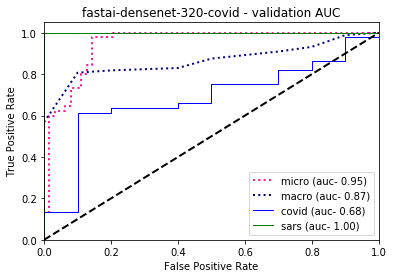

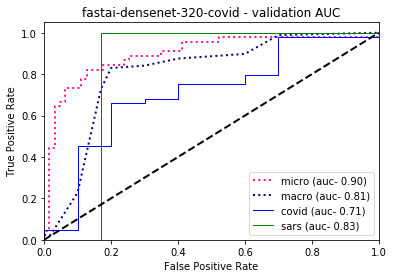

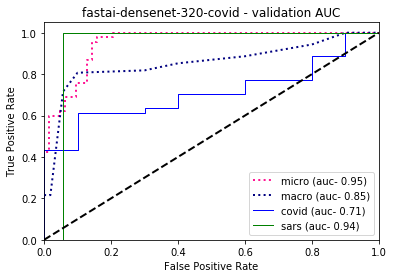

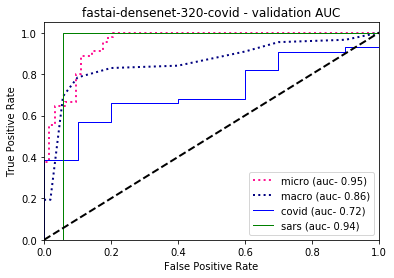

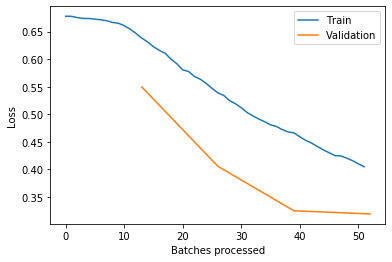

In [56]:
learn.freeze()
learn.fit_one_cycle(4, max_lr=1e-2)
learn.recorder.plot_losses()
learn.save(EXP+'-stage-1')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


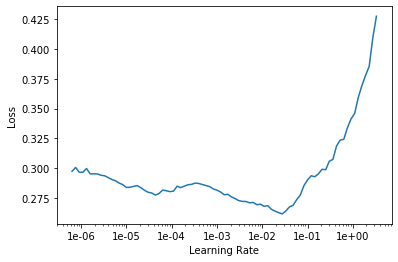

In [57]:
learn.freeze()
learn.lr_find();
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy_thresh,covid-AUC,sars-AUC,micro-AUC,time
0,0.129903,0.285073,0.888889,0.793182,1.000000,0.957672,00:13
1,0.127313,0.282389,0.898148,0.793182,1.000000,0.959436,00:12
2,0.119908,0.276264,0.888889,0.788636,1.000000,0.959083,00:14
3,0.116437,0.298568,0.898148,0.788636,1.000000,0.948501,00:14


roc-auc curve saved to results/fastai-densenet-320-covid/valid_ROC_AUC.png
roc-auc curve saved to results/fastai-densenet-320-covid/valid_ROC_AUC.png
roc-auc curve saved to results/fastai-densenet-320-covid/valid_ROC_AUC.png
roc-auc curve saved to results/fastai-densenet-320-covid/valid_ROC_AUC.png


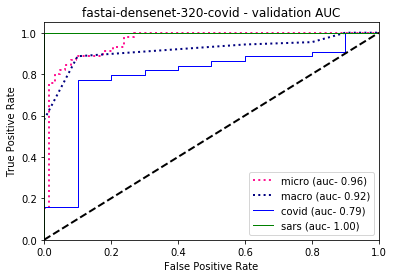

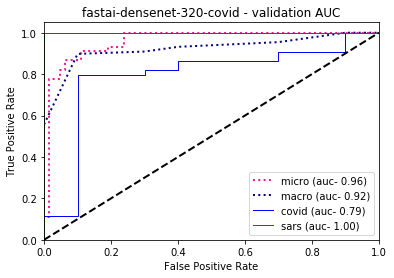

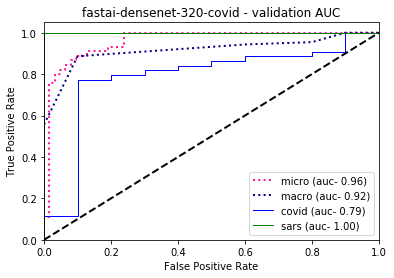

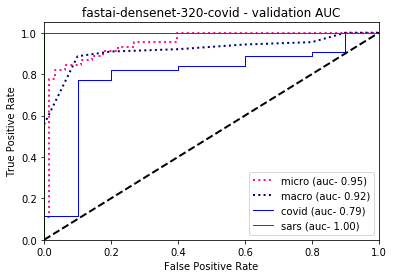

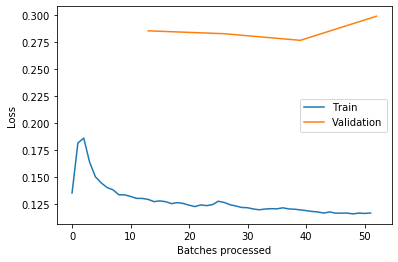

In [58]:
learn.load(EXP+'stage-1')
learn.freeze()
learn.fit_one_cycle(4, max_lr=1e-3)
learn.recorder.plot_losses()
learn.save(EXP+'stage-2')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


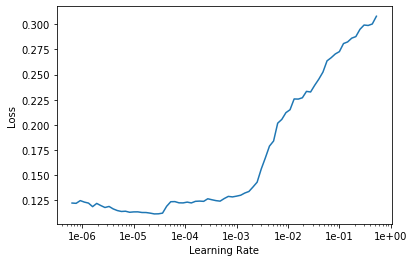

In [59]:
learn.unfreeze()
learn.lr_find();
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy_thresh,covid-AUC,sars-AUC,micro-AUC,time
0,0.109633,0.306619,0.898148,0.786364,1.000000,0.943915,00:20
1,0.122377,0.299282,0.898148,0.795455,1.000000,0.947443,00:18
2,0.122589,0.306307,0.898148,0.788636,1.000000,0.942857,00:17
3,0.120249,0.292898,0.898148,0.790909,1.000000,0.952734,00:20


roc-auc curve saved to results/fastai-densenet-320-covid/valid_ROC_AUC.png
roc-auc curve saved to results/fastai-densenet-320-covid/valid_ROC_AUC.png
roc-auc curve saved to results/fastai-densenet-320-covid/valid_ROC_AUC.png
roc-auc curve saved to results/fastai-densenet-320-covid/valid_ROC_AUC.png


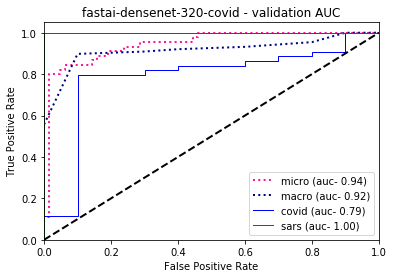

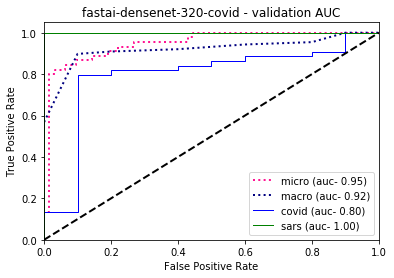

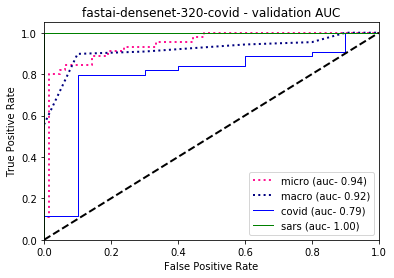

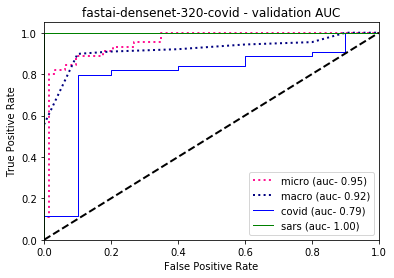

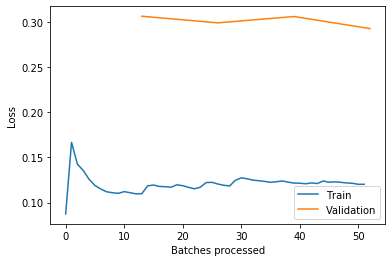

In [60]:
learn.save(EXP+'-stage-1')
learn.freeze()
learn.fit_one_cycle(4, max_lr=slice(1e-5, 3*1e-5))
learn.recorder.plot_losses()
learn.save(EXP+'stage-2')

In [ ]:
learn = cnn_learner(data, models.densenet121, metrics=[acc_02, AUC(pick=0), AUC(pick=1), AUC(pick='micro', plot_auc=True, plot_path=RES_DIR+'valid_ROC_AUC.png')], model_dir='../fastai/models/')
learn.load('fastai-densenet-320-covid-stage-1')
learn.validate(data.valid_dl);

roc-auc curve saved to results/fastai-densenet-320-covid/valid_ROC_AUC.png


roc-auc curve saved to results/fastai-densenet-320-covid/valid_ROC_AUC.png


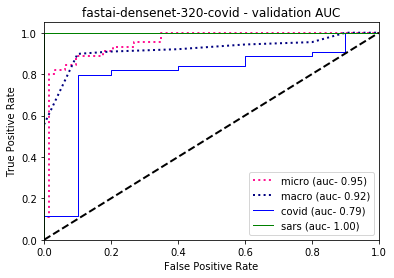

In [62]:
learn = cnn_learner(data, models.densenet121, metrics=[acc_02, AUC(pick=0), AUC(pick=1), AUC(pick='micro', plot_auc=True, plot_path=RES_DIR+'valid_ROC_AUC.png')], model_dir='../fastai/models/')
learn.load('fastai-densenet-320-covidstage-2')
learn.validate(data.valid_dl);